In [5]:
import pandas as pd 
import numpy as np

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool

import matplotlib.pyplot as plt


## Variance estimation 

Let $X \sim U[-2,2]$ and 

\begin{equation}
Y_i=a\left\{X_i+2 \exp \left(-16 X_i^2\right)\right\}+\sigma\left(X_i\right) \varepsilon_i
\end{equation}

where $\varepsilon \sim \mathcal{N} \left(0,1\right)$. The variance function is described by

\begin{equation}
\sigma \left(x \right) = 0.4 \exp \left(-2 x^2\right)+0,2.
\end{equation}

We investigate the performance of 3 different variance estimators 

#### 1. Direct Estimator 

Härdle and Tsybakov propose the direct estimator 

\begin{equation}
\sigma^2(X)=\mbox{ E}\left(Y^2 \mid X\right)-\{m(X)\}^2,
\end{equation}

where $m$ is estimated with $m_n \left(\cdot \right)$ and the other term $\mbox{E}\left(Y^2 \mid X\right)$ is estimated with a nonparametric regression estimator $v_n\left(\cdot, \mathcal{D}_n\right):[0,1] \rightarrow \mathbb{R}_{+}$. 

In [6]:
#Setting 
#Hyperparameter set-up

n = 10000
#h=0.2
a=0.5

b0 = -0.5
b1 = -0.5

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()


eps = eps(0, 1,  n)

y = fan(X,n,a,eps)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [4]:
df['res_sq'] = df['res'].apply(lambda t: t**2)

df['y_sq'] = df['y'].apply(lambda t: t**2)

In [5]:
df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [6]:
v_n = KernelReg(endog=[df.y_sq],exog=[df.x],reg_type='ll',var_type='c', bw='0.1')

m_n = KernelReg(endog=[df.y],exog=[df.x],reg_type='ll',var_type='c', bw='0.1')

#mn_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')



In [7]:
def r_parallel(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [8]:
%%time
# r_parallel(0.1)
#h_ipw = minimize(r_parallel, 0.1).x

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


In [9]:
n = len(df)

In [10]:
var_est = v_n.fit(np.linspace(-2, 2, n))[0] - (m_n.fit(np.linspace(-2, 2, n))[0])**2

In [11]:
def sigma_dir(h,x,X,y):
    Kernel = norm.pdf(x-X/h)
    
    #Estimate Y_n 
    num = sum(y*Kernel)
    den = sum(Kernel)
    mn= num/den
    
    #Estimate vn
    num = sum((y**2)*Kernel)
    den = sum(Kernel)
    vn = num/den
    return vn #- (mn)**2

In [12]:
df['x'].max()

-1.594234632306954

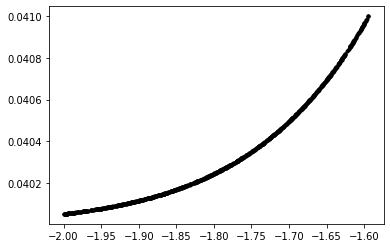

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['x'],sigma_reg(df['x'],n)**2,'o', color='black',markersize=3)

#ax.plot(np.linspace(-2, 1.6, n),[sigma_dir(0.05,t,df['x'],df['y']) for t in np.linspace(-2,2,n)],var_est,color= 'red', lw=3)




In [14]:
import numpy as np
from scipy.stats import norm

### Kernel function fixed Kernel and common bandwidth h

In [15]:
sigma_dir(0.1,0.1,df['x'],df['y'])

0.6563218599396502